In [ ]:
import ast
import os
import json
import re
import time
import datetime
import csv
from typing import Set, Optional, Dict, Any, List, Tuple

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

from openai import OpenAI, RateLimitError, APIConnectionError
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from pygments import highlight
from pygments.lexers import PythonLexer,get_lexer_by_name
from pygments.formatters import TerminalFormatter
from tenacity import retry, wait_exponential, stop_after_attempt

# Local modules
from tool.cellpose_tool import Cellpose2D
from tool.microscope import MicroscopeController
from tool.fiji import ImageJProcessor
from utils.agent_utils import HistoryManager, StorageManager
from agent.check_agent import AgentCheckResult
from config.agent_config import cfg_tabletop, openai_api_key, base_url, vlm_api_key, vlm_base_url

e:\anconda\envs\llmm\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import logging
from typing import List
logging.basicConfig(
    level=logging.INFO,
    format="%(message)s"
)
# Suppress redundant urllib3 logs
logging.getLogger("urllib3").setLevel(logging.WARNING)
logger = logging.getLogger(__name__)

In [ ]:
class SayCapture:
    def __init__(self):
        self.messages: List[str] = []

    def say(self, message):
        msg_str = str(message)
        self.messages.append(msg_str)
        print(f"[Robot action] {msg_str}")

    def get_messages(self) -> List[str]:
        return self.messages.copy()

    def clear(self):
        self.messages.clear()
        
        
def _parse_json_response(content: str) -> Optional[List[Dict]]:
    try:
        content = content.strip()
        if content.startswith("```json"):
            content = content.split("```json")[-1].split("```")[0].strip()
        return json.loads(content)
    except json.JSONDecodeError as e:
        logger.error(f"JSON parsing failed: {e}\nContent:\n{content}")
        return None
    except Exception as e:
        logger.error(f"Unexpected error during JSON parsing: {e}")
        return None

def remove_all_imports(code_text: str) -> str:
    if not code_text:
        return ""
    lines = code_text.split('\n')
    filtered = [line for line in lines if not (
        line.strip().startswith("import ") or
        (line.strip().startswith("from ") and not line.strip().startswith("from ."))
    )]
    return '\n'.join(filtered)

def extract_python_code(text: str) -> str:
    if not text:
        return ""
    text = text.strip()
    text = re.sub(r"^\s*'''\s*python\s*'''\s*", "", text, flags=re.IGNORECASE | re.MULTILINE)
    match = re.search(r"```python\s*([\s\S]*?)\s*```", text, re.IGNORECASE)
    return match.group(1).strip() if match else text

def merge_dicts(dicts: List[Dict]) -> Dict:
    result = {}
    if not validate_param_type(dicts, list, "dicts"):
        return result
    for d in dicts:
        if isinstance(d, dict):
            result.update(d)
        else:
            logger.warning(f"Skipping non-dictionary element: {d}")
    return result

def validate_param_type(param: Any, expected_type: type, param_name: str) -> bool:
    if not isinstance(param, expected_type):
        logger.warning(f"Invalid type for {param_name}, expected {expected_type}, got {type(param)}")
        return False
    return True

def exec_safe(code_str: str, gvars: Optional[Dict] = None, lvars: Optional[Dict] = None) -> None:
    if not code_str.strip():
        logger.warning("Code to execute is empty")
        return
    try:
        tree = ast.parse(code_str)
    except SyntaxError as e:
        raise SyntaxError(f"Code syntax error: {e}") from e

    banned_ops = []
    for node in ast.walk(tree):
        if isinstance(node, (ast.Import, ast.ImportFrom)):
            mod = node.module or ",".join(alias.name for alias in node.names)
            banned_ops.append(f"Import prohibited: {mod}")
        elif isinstance(node, ast.Call) and isinstance(node.func, ast.Name):
            if node.func.id in ('exec', 'eval', 'compile', '__import__'):
                banned_ops.append(f"Dangerous function prohibited: {node.func.id}")

    if banned_ops:
        raise RuntimeError("Unsafe operations detected:\n" + "\n".join(banned_ops))

    # Execute code
    custom_gvars = merge_dicts([gvars or {}, {
        'exec': lambda *a, **k: None,
        'eval': lambda *a, **k: None,
        'compile': lambda *a, **k: None
    }])
    try:
        exec(code_str, custom_gvars, lvars or {})
    except Exception as e:
        logger.error(f"Code execution failed: {e}")
        raise

def var_exists(name: str, all_vars: Dict) -> bool:
    if not (validate_param_type(all_vars, dict, "all_vars") and name.strip()):
        return False
    try:
        return name in all_vars or any(
            name in frame for frame in all_vars.get('__dict__', {}).values()
            if isinstance(frame, dict)
        )
    except Exception:
        return False

def call_openai_generic(
    client: OpenAI, 
    prompt: str,
    system_prompt: str = "",
    model: str = "gpt-3.5-turbo",
    temperature: float = 0.7,
    stop_tokens: list = None,
    stream: bool = False
) -> Any:
    stop_tokens = stop_tokens or []
    while True:
        try:
            return client.chat.completions.create(
                model=model,
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": prompt}
                ],
                stop=stop_tokens,
                temperature=temperature,
                stream=stream
            )
        except (RateLimitError, APIConnectionError) as e:
            logger.error(f"API error: {e}, retrying in 10 seconds")
            time.sleep(10)
        except Exception as e:
            logger.error(f"Unexpected request error: {e}")
            raise


def extract_task_ready(input_text: str) -> str:
    match = re.search(r'<Task Ready>(.*?)</Task Ready>', input_text, re.DOTALL)
    return match.group(1).strip() if match else ""

def extract_task_steps(input_text: str) -> str:
    match = re.search(r'<Task steps>(.*?)</Task steps>', input_text, re.DOTALL)
    return match.group(1).strip() if match else ""

def merge_module_tasks(task_list: List[Dict]) -> List[Dict]:
    if not task_list:
        return []
    merged = []
    current = None
    for task in task_list:
        if not isinstance(task, dict) or not task.get('module') or not task.get('command'):
            logger.warning(f"Skipping invalid task: {task}")
            continue
        if current is None:
            current = {'subtask_index': 1, 'module': task['module'], 'command': task['command']}
        elif current['module'] == task['module']:
            current['command'] += f"; \n#{task['command']}"
        else:
            merged.append(current)
            current = {'subtask_index': len(merged)+1, 'module': task['module'], 'command': task['command']}
    if current:
        merged.append(current)
    return merged

In [ ]:
def explain_planned_execution(client, lmp_steps: list) -> str:
    """
    Generate a short, natural English preview of what the assistant will do next,
    based on raw lmp_steps, using first-person future tense and ending with a gentle confirmation.
    """
    if not lmp_steps:
        return "No actions planned. Would you like to proceed?"

    # Preserve raw module/command format for LLM understanding
    steps_text = "\n".join(
        f"{i+1}. [{step.get('module', 'Unknown')}] {step.get('command', '').strip()}"
        for i, step in enumerate(lmp_steps)
    )

    prompt = f"""You are a helpful AI lab assistant. Before executing a task, briefly explain in one short, natural English sentence what you will do next.

    Planned steps:
    {steps_text}

    Requirements:
    - Use first-person future tense (e.g., "I will...")
    - Translate technical steps into plain lab actions (e.g., "set_objective 20x" → "switch to the 20x objective")
    - Do NOT mention module names, brackets, or internal command syntax
    - End with a gentle confirmation question like "OK?", "Shall I start?", or "Ready to proceed?"

    Output ONLY the sentence. No extra text, explanations, or formatting."""

    try:
        response = client.chat.completions.create(
            model="anthropic/claude-sonnet-4",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.2,
            max_tokens=80
        )
        return response.choices[0].message.content.strip()
    except Exception:
        return "I'll execute the planned steps. Ready to proceed?"
    
    
def summarize_spoken_messages(client, spoken_messages):
    if not spoken_messages:
        return "(No spoken output)"

    messages_text = "\n".join(f"- {msg}" for msg in spoken_messages)
    prompt = f"""Summarize the following robot spoken messages into one or two concise and coherent English sentences. Use third-person perspective and do not add any information beyond what is provided:
{messages_text}
"""

    response = client.chat.completions.create(
        model='anthropic/claude-sonnet-4',
        messages=[
            {"role": "system", "content": "You are an objective observer tasked with summarizing the robot's verbal behavior."},
            {"role": "user", "content": prompt}
        ],
        temperature=0.3,
        max_tokens=150
    )
    return response.choices[0].message.content.strip()


def summarize_task_execution(client, user_command: str, lmp_steps: list) -> str:
    """
    Use an LLM to summarize the user's command and the execution steps.
    """
    if not lmp_steps:
        step_desc = "(No execution steps)"
    else:
        steps = []
        for step in lmp_steps:
            idx = step.get('subtask_index', '?')
            module = step.get('module', 'Unknown')
            cmd = step.get('command', '').strip()
            steps.append(f"{idx}. [{module}] {cmd}")
        step_desc = "\n".join(steps)

    prompt = f"""You are an intelligent lab assistant. Generate a concise English summary of the task execution based on the following information:

    User's original command:
    "{user_command}"

    Actual execution steps:
    {step_desc}

    Summarize the task's implementation process in one or two sentences using third-person, objective tone, and end with a gentle, guiding question about the next step."""

    try:
        response = client.chat.completions.create(
            model="anthropic/claude-sonnet-4",
            messages=[
                {"role": "system", "content": "You excel at summarizing experimental workflows with concise and professional language."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.3,
            max_tokens=250
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        return f"[Task summary failed: {str(e)}]"
    
def summarize_my_spoken_messages(client, spoken_messages):
    if not spoken_messages:
        return "(No spoken output)"

    messages_text = "\n".join(f"- {msg}" for msg in spoken_messages)
    prompt = f"""Summarize the following spoken messages into one or two concise and coherent English sentences, as if you are the speaker describing your own actions or intentions. Use first-person perspective (e.g., 'I will...', 'I am...') and do not add any information beyond what is provided:
{messages_text}
"""

    response = client.chat.completions.create(
        model='anthropic/claude-sonnet-4',
        messages=[
            {"role": "system", "content": "You are summarizing your own spoken messages from a first-person perspective."},
            {"role": "user", "content": prompt}
        ],
        temperature=0.3,
        max_tokens=150
    )
    return response.choices[0].message.content.strip()

In [ ]:

from config.agent_config import cross_encoder_model_path, task_similarity_threshold
class TaskManager:
    def __init__(
        self,
        name: str,
        cfg: Dict,
        client: OpenAI,
        historymanager=None,
        fix_bug=False,
        clarify_tag=False
    ):
        self._name = name
        self._cfg = cfg or {}
        self._base_prompt = self._cfg.get('prompt_text', "")
        self._historyManager = historymanager
        self.code_history = []
        self._stop_tokens = list(self._cfg.get('stop', []))
        self.fix_bug = fix_bug
        self.observation_object = None
        self._client = client
        self.clarify = None
        if clarify_tag:
            try:
                self.clarify = Clarify(self._client, self._base_prompt, self._cfg.get('engine'), cross_encoder_model_path, task_similarity_threshold)
            except Exception as e:
                print(f"Failed to initialize clarifier: {e}")

    def clear_history(self):
        self.code_history = []
        self.observation_object = None

    def build_prompt(self, query: str, context: str = '') -> Tuple[str, str, str]:
        prompt_parts = []
        if self._cfg.get('maintain_session') and self.code_history:
            max_hist = self._cfg.get('max_history', 10)
            prompt_parts.append(f"Historical tasks:\n{json.dumps(self.code_history[-max_hist:], indent=2)}")
        if context.strip():
            prompt_parts.append(context)
        query = f"{self._cfg.get('query_prefix', '')}{query}{self._cfg.get('query_suffix', '')}"
        prompt_parts.append(query)
        return self._base_prompt, "\n".join(prompt_parts), query

    def __call__(self, query: str, context: str = '') -> Tuple[bool, str, Any, Optional[Dict[str, int]]]:
        base_prompt, prompt, use_query = self.build_prompt(query, context)
        usage_dict = None

        if self.clarify:
            answer_content = self.clarify.generate_code_solutions(prompt)
        else:
            response = call_openai_generic(
                client=self._client,
                prompt=prompt,
                system_prompt=base_prompt,
                model=self._cfg.get('engine', 'gpt-3.5-turbo'),
                temperature=self._cfg.get('temperature', 0.7),
                stop_tokens=self._stop_tokens,
                stream=False
            )
            answer_content = response.choices[0].message.content or ""
            usage_dict = {
                "prompt_tokens": response.usage.prompt_tokens,
                "completion_tokens": response.usage.completion_tokens,
                "total_tokens": response.usage.total_tokens
            }


        try:
            ready_content = extract_task_ready(answer_content)
            if not ready_content:
                return False, "", None, usage_dict
            data = json.loads(ready_content)
            if data.get("Status") != 'OK':
                return False, "", None, usage_dict
            steps_content = extract_task_steps(answer_content)
            tasks = _parse_json_response(steps_content)
            if tasks:
                tasks = merge_module_tasks(tasks)
                return True, "", tasks, usage_dict
        except Exception as e:
            print(f"Task parsing failed: {e}")
        return False, "", None, usage_dict

    def _highlight_list(self, items: List) -> str:
        parts = []
        for item in items:
            try:
                if isinstance(item, str):
                    lexer = PythonLexer() if 'def ' in item else get_lexer_by_name('json')
                else:
                    item = json.dumps(item, indent=2)
                    lexer = get_lexer_by_name('json')
                parts.append(highlight(item, lexer, TerminalFormatter()))
            except Exception as e:
                parts.append(str(item))
        return "\n".join(parts)

    def _process_observation_object(self, command: str) -> Tuple[Optional[str], str]:
        if self.observation_object:
            return self.observation_object, command

        system_prompt = (
            "You are an accurate instruction parser. Please extract the unique and specific observation object (such as an object, entity, target, etc.) from the following user instruction.\n"
            "You must strictly return it in the following JSON format, and only return this line without any explanations, prefixes, suffixes or Markdown:"
            '{"object": "Extracted object name"}\n'
            "Example:\n"
            "Instruction: Take a focused photo of the 2D cell section\n"
            '{"object": "2D cell section"}\n\n'
            "Now please process the following instruction:"
        )
        user_prompt = command.strip()

        try:
            response = call_openai_generic(
                client=self._client,
                prompt=user_prompt,
                system_prompt=system_prompt,
                model=self._cfg.get('engine', 'gpt-3.5-turbo'),
                temperature=0.0,
                stream=False
            )
            raw_content = response.choices[0].message.content or ""
            raw_content = raw_content.strip()

            json_match = re.search(r'\{[^{}]*\}', raw_content, re.DOTALL)
            if not json_match:
                obj_match = re.search(r'"object"\s*:\s*"([^"]*)"', raw_content)
                if obj_match:
                    obj_name = obj_match.group(1).strip()
                    self.observation_object = obj_name if obj_name else None
                else:
                    self.observation_object = None
            else:
                json_str = json_match.group(0)
                try:
                    parsed = json.loads(json_str)
                    self.observation_object = parsed.get("object", "").strip() or None
                except json.JSONDecodeError:
                    try:
                        fixed_json = json_str.replace("'", '"')
                        parsed = json.loads(fixed_json)
                        self.observation_object = parsed.get("object", "").strip() or None
                    except Exception:
                        self.observation_object = None

            return self.observation_object, command

        except Exception as e:
            self.observation_object = None
            return None, command
    
    def process_instruction(self, command: str) -> Tuple[bool, Any, Optional[Dict[str, int]]]:
        """Interactively process user instructions"""
        obs_obj, instruction = self._process_observation_object(command)
        extent = ""
        while True:
            full_input = f"{instruction}\n{extent}" if extent else instruction
            is_exec, _, tasks, tokens = self.__call__(full_input, f"Observation object: {obs_obj}")
            if is_exec:
                summary_tasks = explain_planned_execution(self._client, tasks)
                print(f'[Robot]{summary_tasks}')
                user_input = input("Supplement instruction (enter 'execute' to start, 'exit' to quit): ").strip()
                print(f'[User]{user_input}')
                execute_keywords = ['execute', 'run', 'start', 'launch', 'perform', 'execute now', 'run task']
                if user_input.lower() in execute_keywords:
                    if self._historyManager:
                        self._historyManager.append(f"Instruction: {command}\nTasks: {tasks}", self._name)
                    self.code_history.append(json.dumps(tasks))
                    return True, tasks, tokens
                elif user_input.lower() == 'exit':
                    return False, None, None
                else:
                    extent = user_input
            else:
                user_input = input("Task not supported, please re-enter ('exit' to quit): ").strip()
                if user_input.lower() == 'exit':
                    return False, None, None
                instruction = user_input
                extent = ""


# ===================== Core Class: Clarify =====================
class Clarify:
    def __init__(self, client: OpenAI, base_prompt: str, model_name: str, semantic_model_dir, threshold):
        self._base_prompt = base_prompt
        self._model_name = model_name
        self._semantic_model = SentenceTransformer(semantic_model_dir)
        self.threshold = threshold
        self.PROMPT = "Represent this sentence for semantic similarity comparison: "

        # Zero-width/invisible character pool
        self._ZERO_WIDTH_CHARS = [
            "\u200B",  # Zero Width Space
            "\u200C",  # Zero Width Non-Joiner
            "\u200D",  # Zero Width Joiner
            "\u2060",  # Word Joiner
            "\uFEFF",  # Zero Width No-Break Space (BOM)
        ]
        self._CONTROL_CHARS = [
            "\u0000",  # Null
            "\u0001",  # Start of Header
            "\u0002",  # Start of Text
            "\u0003",  # End of Text
        ]
        self._client = client

    def _query_llm(self, prompt: str, _temperature, num_outputs: int = 1,
                   base_prompt="You are a helpful coding assistant.",
                   use_perturbation: bool = True):

        @retry(
            stop=stop_after_attempt(3),
            wait=wait_exponential(multiplier=1, min=1, max=5)
        )
        def _single_query(call_index):
            if use_perturbation:
                # Fixed high perturbation sampling parameters (seed changes with call_index)
                temperature = 1.5  # High temperature → more randomness
                top_p = 0.75  # Low top_p → more extreme sampling
                seed_value = 4242 + call_index  # Deterministic but different each time

                # Deterministic zero-width suffix (based on call_index)
                num_zw = 5
                # Cycle through predefined zero-width characters for reproducibility
                zw_suffix = "".join(
                    self._ZERO_WIDTH_CHARS[i % len(self._ZERO_WIDTH_CHARS)]
                    for i in range(num_zw)
                )

                # Deterministic control character prefix (100% added, fixed content)
                num_ctrl = 3
                ctrl_prefix = "".join(
                    self._CONTROL_CHARS[i % len(self._CONTROL_CHARS)]
                    for i in range(num_ctrl)
                )

                # Fixed trailing whitespace
                trailing_spaces = " " * 3
                trailing_newlines = "\n" * 2

                perturbed_prompt = ctrl_prefix + prompt + zw_suffix + trailing_spaces + trailing_newlines

            else:
                # No perturbation: use original parameters
                temperature = _temperature
                top_p = 1.0
                seed_value = 42 + call_index if _temperature > 0 else 42
                perturbed_prompt = prompt

            response = self._client.chat.completions.create(
                model=self._model_name,
                messages=[
                    {"role": "system", "content": base_prompt},
                    {"role": "user", "content": perturbed_prompt}
                ],
                extra_body={
                    "enable_thinking": False,
                    "thinking": {"type": "disabled"},
                    "return_usage": True
                },
                temperature=temperature,
                top_p=top_p,
                seed=seed_value
            )
            return response.choices[0].message.content

        results = []
        for i in range(num_outputs):
            try:
                result = _single_query(i)
                results.append(result)
            except Exception as e:
                print(f"Query {i + 1} failed after maximum retries: {str(e)}")
        return results

    def _compare_commands(self, task1, task2):
        """
        Compare semantic similarity of two task lists, treating each command as a whole without # chunking.
        """
        if len(task1) != len(task2):
            return 0.0

        modules1 = [item.get('module', '') for item in task1]
        modules2 = [item.get('module', '') for item in task2]

        if modules1 != modules2:
            return 0.0

        total_score = 0.0
        num_modules = len(task1)

        for item1, item2 in zip(task1, task2):
            cmd1 = item1.get('command', '').strip() or "[Empty command]"
            cmd2 = item2.get('command', '').strip() or "[Empty command]"

            # Treat the entire command as a single sentence without chunking
            sentences = [self.PROMPT + cmd1, self.PROMPT + cmd2]
            embeddings = self._semantic_model.encode(sentences, normalize_embeddings=True)
            raw_sim = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]

            total_score += raw_sim

        avg_score = total_score / num_modules if num_modules > 0 else 0.0

        return avg_score

    def _run_semantic_model(self, task_lists):
        """Run semantic model to check consistency"""
        if len(task_lists) < 2:
            return True  # Single solution is considered consistent by default

        tasks = []
        for task in task_lists:
            content = extract_task_steps(task)
            content = _parse_json_response(content)
            content = merge_module_tasks(content)
            tasks.append(content)

        n = len(tasks)
        if n < 2:
            return True

        scores = []
        for i in range(n):
            for j in range(i + 1, n):
                score = self._compare_commands(tasks[i], tasks[j])
                scores.append(score)

        min_score = min(scores) if scores else 1.0
        inconsistency_score = 1 - min_score
        return inconsistency_score <= self.threshold

    def _analyze_semantic_consistency(self, current_query: str, solutions: List[str]) -> Dict[str, Any]:
        """Analyze semantic consistency and generate user-oriented clarification questions"""
        # Step 1: Quick consistency check using semantic model
        if self._run_semantic_model(solutions):
            # Consistent: No need to call LLM, return standard consistent result directly
            return {
                "consistent": True,
                "summary": "All solutions are highly consistent in task understanding.",
                "differences": [],
                "clarification_question": ""
            }

        analyze_prompt = f"""
            Please analyze whether the following {len(solutions)} solutions are consistent in terms of user intent and task understanding.

            Focus on:
            - Are different assumptions being made about unspecified user requirements?
            - Are there fundamental disagreements?

            Requirements:
            - If there are discrepancies in understanding, generate a **concise, natural, user-oriented** clarification question based on these discrepancies to help the user clarify ambiguous needs.
            - The clarification question should focus on the one or two most critical ambiguous points and avoid being verbose.

            Output strictly in JSON format with the following fields:
            {{
                "consistent": true/false,
                "summary": "The core intent commonly expressed by all solutions (one sentence)",
                "differences": ["Understanding difference 1 caused by ambiguous user requirements", ...],
                "clarification_question": "[Specific question]?"
            }}

            User's original task: {current_query}

            Proposed solutions:
            """ + "\n\n".join(f"Solution {i + 1}:\n{s}" for i, s in enumerate(solutions)) + f"\n{'-' * 50}"

        response = self._query_llm(
            prompt=analyze_prompt,
            num_outputs=1,
            base_prompt="",
            _temperature=0,
            use_perturbation=False
        )

        return self._parse_analysis_response(response[0] if response else "", "semantic_consistency")

    def _analyze_violations(self, current_query: str, solutions: List[str]) -> Dict[str, Any]:
        """Check compliance issues in multiple solutions and generate user-oriented clarification questions"""
        solution_list = []
        for solution in solutions:
            steps = extract_task_steps(solution)
            task = _parse_json_response(steps)
            if task:
                task = merge_module_tasks(task)
                solution_list.append(str(task))

        solutions = solution_list

        rules_context = """
        Microscope Operation and System Module Notes:
            3D samples must have Z-stack scanning parameters set (e.g., organoids, cell clusters).
            There is no independent hardware-based autofocus; focusing must be implemented via software based on image feedback.
            Focusing should be performed using the final exposure and light source brightness settings. If imaging parameters are already determined before a focusing operation, re-adjustment is unnecessary; exposure, brightness, and focusing can be executed independently and do not need to be performed consecutively or as a bundled operation.
            Parameter settings:
                Fluorescence: filter must match the channel, brightness=0, high exposure;
                Brightfield: filter=brightfield, low exposure, auto-brightness enabled.
            Focusing strategy:
                Switching fluorescence channels does not require refocusing;
                When switching between brightfield and fluorescence modes, refocusing must be performed.
                After changing objectives, repositioning, brightness adjustment, and refocusing are required.
        """

        analyze_prompt = f"""You are a microscope operation compliance analysis assistant.

        Please review the high-level plan below for ambiguity, omissions, or non-compliant operations according to the following notes:
        {rules_context}

        Requirements:
        Focus on the following:
        - Whether the plan can fulfill the task requirements.
        - If historical information exists, incorporate it. Any changes to objective magnification or fluorescence must be explicitly stated, specifying the exact fluorescence channel/color or objective magnification (e.g., 4x, 10x, 20x, 40x, 60x).
        - If all proposed plans comply with the rules, return has_violation=false and an empty string for clarification_question.
        - Analyze whether the parameter settings in the plan make unwarranted assumptions about the user's original request.
        - Generate a concise, natural, user-oriented clarification question.

        Important: Your response must be a **pure JSON object**. Do not include any additional content, explanations, Markdown (e.g., ```json), line breaks, or extra text. Output only the following JSON format:
        {{"has_violation": true/false, "clarification_question": "Your question"}}
        User's original task: {current_query}
        User-provided plans:
        {'-' * 50}
        """ + "\n\n".join(f"Plan {i + 1}:\n{s}" for i, s in enumerate(solutions)) + f"\n{'-' * 50}"

        response = self._query_llm(
            prompt=analyze_prompt,
            num_outputs=1,
            base_prompt="",
            _temperature=0,
            use_perturbation=False
        )

        return self._parse_violation_response(response[0] if response else "")

    def _parse_analysis_response(self, response_text: str, analysis_type: str) -> Dict[str, Any]:
        """Parse analysis response with unified error handling"""
        try:
            result = _parse_json_response(response_text)
            required_fields = ["consistent", "summary", "differences", "clarification_question"]

            for field in required_fields:
                if field not in result:
                    raise ValueError(f"Missing field: {field}")

            assert isinstance(result["consistent"], bool)
            assert isinstance(result["summary"], str)
            assert isinstance(result["differences"], list)
            assert isinstance(result["clarification_question"], str)

            return result
        except Exception as e:

            return self._get_default_analysis_response(analysis_type)

    def _parse_violation_response(self, response_text: str) -> Dict[str, Any]:
        """Parse violation analysis response"""
        try:
            result = _parse_json_response(response_text)
            has_violation = result.get("has_violation", False)
            clarification_question = result.get("clarification_question", "").strip() if has_violation else ""
            return {
                "has_violation": has_violation,
                "clarification_question": clarification_question
            }
        except Exception as e:
            return {
                "has_violation": True,
                "clarification_question": "To ensure the feasibility of the plan, please clarify: Do you wish to perform any operations beyond the functionality of the standard microscope module? For example, manual focusing, custom Z-scanning, etc.?"
            }

    def _get_default_analysis_response(self, analysis_type: str) -> Dict[str, Any]:
        """Get default analysis response"""
        if analysis_type == "semantic_consistency":
            return {
                "consistent": False,
                "summary": "Failed to parse consistency result",
                "differences": ["LLM returned invalid format or missing required fields"],
                "clarification_question": "To better assist you, please provide detailed information about your experimental requirements, such as: sample type (2D/3D), fluorescence channels used, objective magnification, etc."
            }
        return {}

    @staticmethod
    def _get_user_feedback(suggested_question: str) -> str:
        """Get user feedback"""
        print(f"\n[System Question] {suggested_question}")
        print(f"\n[Robot] {suggested_question}")
        req = input("Your response: ").strip()
        print(f'[User]{req}')
        return req

    def generate_code_solutions(self, user_input: str, num_solutions: int = 3,
                                max_clarification_rounds: int = 10) -> str:
        """Main workflow for generating code solutions"""
        current_query = user_input
        _query = user_input
        round_count = 0

        while round_count < max_clarification_rounds:
            round_count += 1

            exploration_prompt = (
                f"{current_query}\n\n"
                "Note: The user's request may contain unspecified parameters.\n"
                "Please proactively make different reasonable assumptions about these ambiguous points to generate diverse plans.\n"
                "Maintain the required output format and do not add any content beyond the specified format.\n"
            )

            solutions = self._query_llm(
                prompt=exploration_prompt,
                num_outputs=num_solutions,
                base_prompt=self._base_prompt,
                _temperature=1.0,
                use_perturbation=True)

            if not solutions:
                return ""

            # Step 1: Analyze semantic consistency
            consistency_result = self._analyze_semantic_consistency(_query, solutions)

            # Step 2: Check operational compliance
            violation_result = self._analyze_violations(_query, solutions)

            # Scenario 1: Semantically consistent and no violations → Success, return result
            if consistency_result["consistent"] and not violation_result["has_violation"]:
                return solutions[0]

            # Scenario 2: Semantically inconsistent → Must clarify with user
            if not consistency_result["consistent"]:

                base_diff = consistency_result['differences'][0] if consistency_result[
                    'differences'] else "Please further explain your experimental setup"
                suggested_question = f"To ensure we accurately understand your request, please clarify: {base_diff}?"
                additional_input = self._get_user_feedback(suggested_question)

                # Update context (only for next round of semantic understanding)
                _query = (
                    f"{_query}\n\n"
                    f"System clarification question: {suggested_question}\n"
                    f"User's additional input: {additional_input}"
                )
                current_query = (
                    f"{_query}\n"
                    "Please generate a solution based on the clarified requirements above."
                )
                continue  # Proceed to next round

            # Scenario 3: Semantically consistent but with violations → Auto-integrate suggestions and retry
            if consistency_result["consistent"] and violation_result["has_violation"]:
                suggestion_text = violation_result["clarification_question"]

                # Construct clarification question: Ask user to confirm adjustment or stick to original intent
                clarification_question = (
                    f"{suggestion_text}\n"
                )
                additional_input = self._get_user_feedback(clarification_question)

                # Add user feedback to context and regenerate in next round
                _query = (
                    f"{_query}\n\n"
                    f"System noted a compliance issue: {suggestion_text}\n"
                    f"User response: {additional_input}"
                )
                current_query = (
                    f"{_query}\n"
                    "Please generate a more accurate solution based on the user's clarification and feedback above."
                )

                continue

        return solutions[0] if solutions else "Failed to generate valid solution, please retry or provide more details."

def extract_task_steps(input_text: str) -> str:
    """提取任务步骤"""
    match = re.search(r'<Task steps>(.*?)</Task steps>', input_text, re.DOTALL)
    return match.group(1).strip() if match else ""

In [ ]:
from config.agent_config import cross_encoder_model_path, task_similarity_threshold
class LMP:
    """Language Model Program (accepts external client instance)"""
    def __init__(
        self,
        name: str,
        cfg: Dict,
        lmp_fgen: "LMPFGen",
        fixed_vars: Dict,
        variable_vars: Dict,
        client: OpenAI,  # New: Accept global client instance passed from main program
        _historyManager=None,
        clarify_tag: bool = False
    ):
        self._name = name
        self._cfg = cfg or {}
        self._base_prompt = self._cfg.get('prompt_text', "")
        self._historyManager = _historyManager
        self.clarify_tag = clarify_tag
        self.code_history = ''
        self._lmp_fgen = lmp_fgen
        self._fixed_vars = fixed_vars or {}
        self._variable_vars = variable_vars or {}
        self._client = client  # Cache: Save global client instance

    def clear_exec_hist(self):
        """Clear code execution history"""
        self.code_history = ''

    def build_prompt(self, query: str, context: str = '') -> Tuple[str, str, str]:
        """Construct LLM prompt"""
        prompt_parts = []
        # Session history
        if self._cfg.get('maintain_session') and self.code_history.strip():
            prompt_parts.append(self.code_history)
        # Context
        if context.strip():
            prompt_parts.append(context)
        # Query
        query = f"{self._cfg.get('query_prefix', '')}{query}{self._cfg.get('query_suffix', '')}"
        prompt_parts.append(f"{query}\n# Generate runnable Python code without markdown")
        return self._base_prompt, "\n".join(prompt_parts), query

    def __call__(self, query: str, context: str = '', **kwargs) -> Optional[Dict[str, int]]:
        base_prompt, prompt, use_query = self.build_prompt(query, context)

        # ========== Core Modification 1: Disable streaming output (stream=False) ==========
        response = call_openai_generic(
            client=self._client,  # Reuse global client instance
            prompt=prompt,
            system_prompt=base_prompt,
            model=self._cfg.get('engine', 'gpt-3.5-turbo'),
            temperature=self._cfg.get('temperature', 0.7),
            stop_tokens=list(self._cfg.get('stop', [])),
            stream=False  # Disable streaming to get complete response
        )

        # ========== Core Modification 2: Parse complete response to get content at once ==========
        reasoning_content, answer_content = "", ""
        usage_dict = None

        # Parse complete response (non-streaming response structure is different from streaming)
        if hasattr(response, 'choices') and response.choices:
            # Get complete answer content
            answer_content = response.choices[0].message.content or ""
        
        # Parse usage information (non-streaming usage is directly in the root node of response)
        if hasattr(response, 'usage') and response.usage:
            usage_dict = {
                "prompt_tokens": response.usage.prompt_tokens,
                "completion_tokens": response.usage.completion_tokens,
                "total_tokens": response.usage.total_tokens
            }

        # ========== Keep original logic (extract code, output, execute) ==========
        # Extract and clean up code
        code_str = extract_python_code(answer_content)
        code_str = remove_all_imports(code_str)
        to_log = f"{use_query}\n# Reasoning:\n{reasoning_content}\n# Code:\n{code_str}"
        
        # Output code at once (replace original streaming output)
        print("\n===== Executing Code =====")
        print(highlight(code_str, PythonLexer(), TerminalFormatter()))

        # Log recording
        if self._historyManager:
            self._historyManager.append(to_log, self._name)
        
        # Execute code (when not in debug mode)
        if not self._cfg.get('debug_mode'):
            try:
                gvars = merge_dicts([self._fixed_vars, self._variable_vars])
                print("\n===== Execution Process =====")
                exec_safe(code_str, gvars, kwargs)
                if self._cfg.get('maintain_session'):
                    self._variable_vars.update(kwargs)
                self.code_history += f"\n{code_str}"
            except Exception as e:
                print(f"Code execution failed: {e}")

        return usage_dict

# ===================== Core Class: LMPFGen (Function Generator) =====================
class LMPFGen:
    """LLM-based Function Generator (accepts external client instance)"""
    def __init__(
        self,
        cfg: Dict,
        fixed_vars: Dict,
        variable_vars: Dict,
        client: OpenAI  # New: Accept global client instance passed from main program
    ):
        if not validate_param_type(cfg, dict, "cfg"):
            raise TypeError("cfg must be a dictionary")
        self._cfg = cfg
        self._stop_tokens = list(cfg.get('stop', []))
        self._fixed_vars = fixed_vars or {}
        self._variable_vars = variable_vars or {}
        self._base_prompt = cfg.get('prompt_text', "")
        self._client = client  # Cache: Save global client instance for subsequent reuse

    def create_f_from_sig(
        self,
        f_name: str,
        f_sig: str,
        other_vars: Optional[Dict] = None,
        return_src: bool = False
    ) -> Any:
        logger.debug(f'Creating function: {f_sig}')
        # Construct prompt (unchanged)
        query = f"{self._cfg.get('query_prefix', '')}{f_sig}{self._cfg.get('query_suffix', '')}"
        prompt = f"{self._base_prompt}\n{query}"

        # Call generic function: Pass cached client instance (reuse)
        response = call_openai_generic(
            client=self._client,  # Reuse global client passed from main program
            prompt=prompt,
            model=self._cfg.get('engine', 'gpt-3.5-turbo'),
            temperature=self._cfg.get('temperature', 0.7),
            stop_tokens=self._stop_tokens,
            stream=True
        )

        # Subsequent logic (extract code, safe execution, etc. - unchanged)
        answer_content = "".join([chunk.choices[0].delta.content or "" for chunk in response])
        f_src = extract_python_code(answer_content)
        f_src = remove_all_imports(f_src)
        logger.debug(f"Generated code:\n{f_src}")

        gvars = merge_dicts([self._fixed_vars, self._variable_vars, other_vars or {}])
        lvars = {}
        exec_safe(f_src, gvars, lvars)

        if f_name not in lvars:
            raise RuntimeError(f"Function {f_name} generation failed")

        logger.debug(f"Function {f_name} created successfully\n")
        return (lvars[f_name], f_src) if return_src else lvars[f_name]

    def create_new_fs_from_code(
        self,
        code_str: str,
        other_vars: Optional[Dict] = None,
        return_src: bool = False
    ) -> Any:
        """Extract function calls from code and recursively generate undefined functions"""
        if not code_str.strip():
            return ({}, {}) if return_src else {}

        # Extract function calls and assignments
        fs, f_assigns = {}, {}
        try:
            FunctionParser(fs, f_assigns).visit(ast.parse(code_str))
        except SyntaxError as e:
            logger.error(f"AST parsing failed: {e}")
            return ({}, {}) if return_src else {}

        # Prioritize assignments as signatures (more complete)
        for f_name, f_assign in f_assigns.items():
            if f_name in fs:
                fs[f_name] = f_assign

        new_fs, srcs = {}, {}
        all_vars = merge_dicts([self._fixed_vars, self._variable_vars, other_vars or {}])

        # Generate undefined functions
        for f_name, f_sig in fs.items():
            if var_exists(f_name, merge_dicts([all_vars, new_fs])):
                continue

            # Generate function (executed and returns function object)
            f, f_src = self.create_f_from_sig(f_name, f_sig, new_fs, return_src=True)
            new_fs[f_name] = f
            srcs[f_name] = f_src

            # Recursively parse new function calls in function body
            try:
                tree = ast.parse(f_src)
                if tree.body and isinstance(tree.body[0], (ast.FunctionDef, ast.AsyncFunctionDef)):
                    # ✅ Use standard library ast.unparse (Python 3.9+)
                    func_body = ast.unparse(tree.body[0].body).strip()
                    if func_body:  # Recurse only if function body is non-empty
                        child_fs, child_srcs = self.create_new_fs_from_code(
                            func_body,
                            merge_dicts([all_vars, new_fs]),
                            return_src=True
                        )
                        new_fs.update(child_fs)
                        srcs.update(child_srcs)
                        # Note: No repeated exec_safe, as child functions are executed in create_f_from_sig
            except Exception as e:
                logger.warning(f"Failed to recursively generate child functions: {e}")

        return (new_fs, srcs) if return_src else new_fs

# ===================== Auxiliary Class: FunctionParser (AST Traverser) =====================
class FunctionParser(ast.NodeTransformer):
    """AST Traverser: Extract function calls and assignment statements"""
    def __init__(self, fs: Dict[str, str], f_assigns: Dict[str, str]):
        super().__init__()
        if not (validate_param_type(fs, dict, "fs") and validate_param_type(f_assigns, dict, "f_assigns")):
            raise TypeError("fs and f_assigns must be dictionaries")
        self._fs = fs
        self._f_assigns = f_assigns

    def visit_Call(self, node: ast.Call):
        """Extract function call signature"""
        self.generic_visit(node)
        if isinstance(node.func, ast.Name):
            try:
                sig = ast.unparse(node).strip()
                func_name = ast.unparse(node.func).strip()
                self._fs[func_name] = sig
            except Exception as e:
                logger.warning(f"Failed to extract function signature: {e}")
        return node

    def visit_Assign(self, node: ast.Assign):
        """Extract function calls in assignment statements"""
        self.generic_visit(node)
        if isinstance(node.value, ast.Call):
            try:
                assign_str = ast.unparse(node).strip()
                func_name = ast.unparse(node.value.func).strip()
                self._f_assigns[func_name] = assign_str
            except Exception as e:
                logger.warning(f"Failed to extract assignment statement: {e}")
        return node

In [ ]:
import base64
import json
import io
import os
import re
import numpy as np
from typing import List, Dict, Optional, Tuple
from dataclasses import dataclass
from openai import OpenAI

try:
    from aicsimageio import AICSImage
except ImportError:
    raise ImportError("Please install aicsimageio: pip install aicsimageio[pillow]")

from PIL import Image
from config.agent_config import vlm_api_key, vlm_base_url, vlm_model_name

from agent.utils import (
    _parse_json_response,
    merge_module_tasks,
    extract_task_steps,
    convert_to_list
)


@dataclass
class ImageDefect:
    """Data class for single-channel/overall image defects"""
    no_target: bool = False  # No target defect
    out_of_focus: bool = False  # Out-of-focus defect
    over_exposed: bool = False  # Overexposure defect
    reason: str = ""  # Defect description


@dataclass
class CheckResult:
    """Data class for complete detection results of a single image (image_id removed)"""
    defects: ImageDefect
    raw_vlm_response: str = ""
    file_info: Optional[Dict] = None
    channel_defects: Optional[List[Dict]] = None  # Channel-level detailed errors

    def to_dict(self) -> Dict:
        """Convert to dictionary, supporting JSON serialization (image_id removed)"""
        return {
            "defects": {
                "no_target": self.defects.no_target,
                "out_of_focus": self.defects.out_of_focus,
                "over_exposed": self.defects.over_exposed,
                "reason": self.defects.reason
            },
            "channel_defects": self.channel_defects,
            "raw_vlm_response": self.raw_vlm_response,
            "file_info": self.file_info
        }


class AgentCheckResult:
    def __init__(self, cfg: Optional[Dict] = None, llm_client: Optional[OpenAI] = None, vlm_client: Optional[OpenAI] = None, output_path = None):
        self._cfg = cfg or {}
        self.results: List[CheckResult] = []
        self.color_channel_mapping = {
            (255, 0, 0): "TRITC",
            (0, 255, 0): "FITC",
            (0, 0, 255): "DAPI",  # Note: Original code maps (0,0,255) -> DAPI, which is blue in RGB, corrected to common combination here
            (128, 120, 128): "brighted"  # Example, adjust according to your actual data
        }
        self.output_directory: str = output_path
        # Initialize OpenAI compatible clients
        if llm_client is not None and vlm_client is not None:
            self._llm_client = llm_client
            self._vlm_client = vlm_client
        else:
            client = OpenAI(base_url=vlm_base_url, api_key=vlm_api_key)
            self._llm_client = client
            self._vlm_client = client

    def clear_history_results(self):
        """Clear all historical detection records"""
        self.results.clear()


    def _parse_channel_names(self, description: str) -> List[str]:
        """Parse channel names (e.g., DAPI/FITC) from file description"""
        pattern = r"channel_names:\s*\[(.*?)\]"
        match = re.search(pattern, description)
        if not match:
            return []

        tuple_str = match.group(1)
        tuple_matches = re.findall(r"\((\d+),\s*(\d+),\s*(\d+)\)", tuple_str)
        channel_names = []
        for rgb in tuple_matches:
            rgb_tuple = (int(rgb[0]), int(rgb[1]), int(rgb[2]))
            channel_name = self.color_channel_mapping.get(rgb_tuple, f"Ch{len(channel_names)}")
            channel_names.append(channel_name)
        return channel_names


    # ================== VLM/LLM Calls (Using OpenAI SDK) ==================
    def _call_vlm_custom(self, image_b64: str, prompt: str) -> Tuple[Optional[Dict], str]:
        """Call VLM model (using OpenAI compatible client)"""
        try:
            response = self._vlm_client.chat.completions.create(
                model=self._cfg.get('vlm_engine'),
                messages=[
                    {
                        "role": "user",
                        "content": [
                            {"type": "text", "text": prompt},
                            {
                                "type": "image_url",
                                "image_url": {
                                    "url": f"data:image/png;base64,{image_b64}"
                                }
                            }
                        ]
                    }
                ],
                temperature=self._cfg.get('vlm_temperature'),
                max_tokens=self._cfg.get('vlm_max_tokens')
            )
            content = response.choices[0].message.content
            if not content:
                return None, "VLM returned empty content"

            parsed = json.loads(content)
            return parsed, content
        except Exception as e:
            return None, f"VLM call failed: {str(e)}"

    def _call_llm_custom(self, prompt: str) -> Tuple[Optional[str], str]:
        """Call LLM (reuse VLM client, assuming text is supported)"""
        try:
            response = self._llm_client.chat.completions.create(
                model=self._cfg.get('engine'),  # Or specify another text model
                messages=[{"role": "user", "content": prompt}],
                temperature=self._cfg.get('temperature'),
                max_tokens=self._cfg.get('max_tokens')
            )
            content = response.choices[0].message.content.strip()
            return content, content
        except Exception as e:
            return None, f"LLM call failed: {str(e)}"

    # ================== Image Preprocessing ==================
    def _array_to_linear_uint8(self, arr: np.ndarray) -> np.ndarray:
        if arr.dtype == np.uint8:
            return arr
        elif arr.dtype == np.uint16:
            return (arr >> 8).astype(np.uint8)
        elif arr.dtype == np.uint32:
            return (arr >> 24).astype(np.uint8)
        elif arr.dtype.kind == 'f':
            max_val = arr.max()
            if max_val <= 0:
                return np.zeros_like(arr, dtype=np.uint8)
            scaled = arr / max_val
            return np.clip(scaled * 255, 0, 255).astype(np.uint8)
        else:
            arr_min, arr_max = arr.min(), arr.max()
            if arr_max == arr_min:
                return np.zeros_like(arr, dtype=np.uint8)
            return ((arr - arr_min) / (arr_max - arr_min) * 255).astype(np.uint8)

    def _array_to_contrast_uint8(self, arr: np.ndarray) -> np.ndarray:
        if arr.dtype != np.uint8:
            p_low, p_high = np.percentile(arr, [0.01, 99.9])
            if p_high == p_low:
                arr_norm = np.zeros_like(arr)
            else:
                arr_norm = np.clip((arr - p_low) / (p_high - p_low), 0, 1)
            arr_uint8 = (arr_norm * 255).astype(np.uint8)
        else:
            arr_uint8 = arr
        return arr_uint8

    def _uint8_to_base64_png(self, arr_uint8: np.ndarray) -> str:
        if arr_uint8.ndim == 2:
            arr_rgb = np.stack([arr_uint8, arr_uint8, arr_uint8], axis=-1)
        else:
            arr_rgb = arr_uint8
        img = Image.fromarray(arr_rgb)
        buf = io.BytesIO()
        img.save(buf, format="PNG")
        return base64.b64encode(buf.getvalue()).decode("utf-8")

    # ================== Image Detection ==================
    def check_ome_tiff_as_single(
        self,
        image_path: str,
        file_info: Optional[Dict] = None
    ) -> CheckResult:
        if not os.path.exists(image_path):
            error_result = CheckResult(
                defects=ImageDefect(reason=f"File does not exist: {image_path}"),
                file_info=file_info,
                channel_defects=[]
            )
            self.results.append(error_result)
            return error_result

        try:
            img = AICSImage(image_path)
            dims = img.dims.order
            num_channels = img.shape[dims.index('C')]

            channel_names = []
            if file_info and "description" in file_info:
                channel_names = self._parse_channel_names(file_info["description"])
            while len(channel_names) < num_channels:
                channel_names.append(f"Ch{len(channel_names)}")

            channel_defects_list = []
            raw_responses = []

            for c in range(num_channels):
                indexer = {"C": c}
                if 'T' in dims:
                    indexer["T"] = 0
                if 'Z' in dims:
                    indexer["Z"] = 0
                plane = img.get_image_data("YX", **indexer)

                linear_uint8 = self._array_to_linear_uint8(plane)
                contrast_uint8 = self._array_to_contrast_uint8(plane)
                b64_linear = self._uint8_to_base64_png(linear_uint8)
                b64_contrast = self._uint8_to_base64_png(contrast_uint8)

                # 1. No target
                no_target_res, no_target_raw = self._call_vlm_custom(b64_contrast, self._cfg.get('prompt_no_target'))
                no_target = bool(no_target_res.get("no_target", False)) if no_target_res else False
                no_target_reason = no_target_res.get("reason", "") if no_target_res else "Detection failed"

                # 2. Overexposure
                over_exposed_res, over_exposed_raw = self._call_vlm_custom(b64_linear, self._cfg.get('prompt_over_exposed'))
                over_exposed = bool(over_exposed_res.get("over_exposed", False)) if over_exposed_res else False
                over_exposed_reason = over_exposed_res.get("reason", "") if over_exposed_res else "Detection failed"

                # 3. Out of focus
                out_of_focus_res, out_of_focus_raw = self._call_vlm_custom(b64_contrast, self._cfg.get('prompt_out_of_focus'))
                out_of_focus = bool(out_of_focus_res.get("out_of_focus", False)) if out_of_focus_res else False
                out_of_focus_reason = out_of_focus_res.get("reason", "") if out_of_focus_res else "Detection failed"

                defects = []
                if no_target:
                    defects.append("No target")
                if out_of_focus:
                    defects.append("Out of focus")
                if over_exposed:
                    defects.append("Overexposed")
                combined_reason = "; ".join(defects) if defects else "Normal"

                channel_defect = {
                    "channel_index": c,
                    "channel_name": channel_names[c],
                    "no_target": no_target,
                    "out_of_focus": out_of_focus,
                    "over_exposed": over_exposed,
                    "reason": combined_reason
                }
                channel_defects_list.append(channel_defect)
                raw_responses.extend([no_target_raw, over_exposed_raw, out_of_focus_raw])

            # Overall defects
            final_no_target = any(cd["no_target"] for cd in channel_defects_list)
            final_out_of_focus = any(cd["out_of_focus"] for cd in channel_defects_list)
            final_over_exposed = any(cd["over_exposed"] for cd in channel_defects_list)

            reason_parts = []
            for cd in channel_defects_list:
                if cd["reason"] != "Normal":
                    reason_parts.append(f"{cd['channel_name']}: {cd['reason']}")
            final_reason = "; ".join(reason_parts) if reason_parts else "All channels are normal"

            final_result = CheckResult(
                defects=ImageDefect(
                    no_target=final_no_target,
                    out_of_focus=final_out_of_focus,
                    over_exposed=final_over_exposed,
                    reason=final_reason
                ),
                raw_vlm_response=" | ".join(raw_responses),
                file_info=file_info,
                channel_defects=channel_defects_list
            )
            self.results.append(final_result)
            return final_result

        except Exception as e:
            error_result = CheckResult(
                defects=ImageDefect(reason=f"Image parsing failed: {str(e)[:50]}"),
                file_info=file_info,
                channel_defects=[]
            )
            self.results.append(error_result)
            return error_result

    def batch_check_from_json(self, image_config: Dict) -> List[CheckResult]:
        results = []
        image_base_dir = self.output_directory

        for file_key, file_info in image_config.items():
            if file_info.get("created_by") != "microscope":
                continue
            if file_info.get("file_type") != "ome-tiff":
                continue

            filename = file_info.get("filename", file_key)
            image_path = os.path.join(image_base_dir, filename) if image_base_dir else filename

            result = self.check_ome_tiff_as_single(
                image_path=image_path,
                file_info=file_info
            )
            results.append(result)

        return results
    
    def summarize_task_defects(self) -> Dict[str, str]:
        if not self.results:
            raise ValueError("No detection results available, please perform image check first")

        task_defect_summary = {}
        for result in self.results:
            filename = result.file_info.get("filename", "Unknown file") if result.file_info else "Unknown file"

            defective_channels = []
            if result.channel_defects:
                for ch in result.channel_defects:
                    defects = []
                    if ch['no_target']:
                        defects.append("No target")
                    if ch['out_of_focus']:
                        defects.append("Out of focus")
                    if ch['over_exposed']:
                        defects.append("Overexposed")
                    if defects:
                        defective_channels.append(f"{ch['channel_name']}({','.join(defects)})")

            file_defect_desc = "; ".join(defective_channels) if defective_channels else "All channels are defect-free (No target/Out of focus/Overexposed)"
            task_defect_summary[filename] = file_defect_desc

        return task_defect_summary

    def generate_task_unified_instruction(self, original_x_y, original_instruction: str):
        task_defect_dict = self.summarize_task_defects()
        global_error_info_parts = ["Summary of channel errors for each file in this task:"]
        for filename, defect_desc in task_defect_dict.items():
            global_error_info_parts.append(f"- {filename}: {defect_desc}")
        global_error_info = "\n".join(global_error_info_parts)

        has_no_target_error = False
        for defect_desc in task_defect_dict.values():
            if "All channels are defect-free" in defect_desc:
                continue
            if "No target" in defect_desc:
                has_no_target_error = True
                break

        if has_no_target_error:
            selected_prompt = self._cfg.get('instruction_prompt_with_no_target').format(
                original_x_y = original_x_y,
                original_instruction=original_instruction,
                global_error_info=global_error_info
            )
        else:
            selected_prompt = self._cfg.get('instruction_prompt_without_no_target').format(
                original_instruction=original_instruction,
                global_error_info=global_error_info
            )

        unified_instruction, _ = self._call_llm_custom(selected_prompt)
        tasks = convert_to_list(unified_instruction)

        return tasks if tasks else "Generation failed"
    

In [7]:
from config.task_config import OUTPUT_DIR, MAX_RETRY_TIMES, RETRY_INTERVAL, HISTORY_DIR
say_capture = SayCapture()

logging.getLogger("openai").setLevel(logging.WARNING)

llm_client = OpenAI(api_key=openai_api_key, base_url=base_url)
vlm_client = OpenAI(api_key=vlm_api_key, base_url=vlm_base_url)

In [ ]:
from config.system_config import CONFIG_PATH, MM_DIR
def initialize_system(history_dir):
    historymanager = HistoryManager(history_dir)
    storageManager = StorageManager(history_dir, OUTPUT_DIR)

    try:
        env_olympus = MicroscopeController(CONFIG_PATH, MM_DIR, OUTPUT_DIR, storageManager)
        env_imagej = ImageJProcessor(storageManager, OUTPUT_DIR)
        env_cellpose = Cellpose2D(storageManager, OUTPUT_DIR)
    except Exception as e:
        raise Exception(f"Core environment initialization failed: {str(e)}")

    fixed_vars = {
        'np': np,
        'cv': cv,
        'datetime': datetime,
        'time': time,
        'csv': csv,
        'json': json,
        'plt': plt
    }
    microscope_methods = [
        'set_x_y_position', 'set_z_position', 'set_exposure', 'set_objective', 'set_channel',
        'set_brightness', 'get_x_y_position', 'get_z_position', 'get_exposure', 'get_objective',
        'get_channel', 'get_brightness', 'start_preview', 'stop_preview',
        'run_acquisition', 'set_z_stack', 'add_acquisition_position', 'add_channels',
        'set_time_series', 'perform_autofocus', 'perform_autobrightness', 'shutdown',
        'initialize', 'z_stack_range', 'load_target_locations','detect_target_tile_positions',
        'check_and_calc_target_position', 'create_24_wells_positions', 'create_96_wells_positions',
        'detect_targets_in_image'
    ]

    olympus_vars = {k: getattr(env_olympus, k) for k in microscope_methods if hasattr(env_olympus, k)}

    # ---- ImageJ methods ----
    imagej_methods = [
        'fiji_initialize', 'fiji_shutdown', 'load_image', 'save_image', 'adjust_contrast',
        'set_lut', 'split_channels', 'merge_channels', 'z_projection', 'denoise',
        'richardson_lucy', 'quantify_fluorescence',
        'analysis_platform_find_tumor_position', 'analysis_platform_find_organoid_position',
        'analysis_platform_find_lesion_position', 'analysis_platform_find_bacteria_position',
        'analysis_platform_find_2Dcell_position',
        'convert_to_numpy'
    ]
    imagej_vars = {k: getattr(env_imagej, k) for k in imagej_methods if hasattr(env_imagej, k)}

    # ---- Cellpose methods ----
    cellpose_methods = [
        "cellpose_initialize", "segment", "analyze_masks", "save_masks", "save_csv", 'cellpose_read'
    ]
    cellpose_vars = {k: getattr(env_cellpose, k) for k in cellpose_methods if hasattr(env_cellpose, k)}

    # Merge variables
    variable_vars = {}
    variable_vars.update(olympus_vars)
    variable_vars.update(imagej_vars)
    variable_vars.update(cellpose_vars)
    variable_vars['say'] = say_capture.say

    try:
        lmp_fgen = LMPFGen(cfg_tabletop['lmps']['fgen'], fixed_vars, variable_vars, llm_client)
        # Initialize each LMP module
        prompt_olympus = LMP('prompt_olympus', cfg_tabletop['lmps']['prompt_olympus'], lmp_fgen, fixed_vars, variable_vars, llm_client, historymanager)
        prompt_imagej = LMP('prompt_imagej', cfg_tabletop['lmps']['prompt_imagej'], lmp_fgen, fixed_vars, variable_vars, llm_client, historymanager)
        prompt_cellpose = LMP('prompt_cellpose', cfg_tabletop['lmps']['prompt_cellpose'], lmp_fgen, fixed_vars, variable_vars, llm_client, historymanager)
        # Initialize task manager
        task_manager = TaskManager(
            'Task_manger',
            cfg_tabletop['lmps']['Task_manger'],
            llm_client,
            historymanager,
            clarify_tag=True
        )
        checker = AgentCheckResult(cfg_tabletop['lmps']['checker'], llm_client, vlm_client, OUTPUT_DIR)
    except KeyError as e:
        raise KeyError(f"Missing key field in configuration table: {str(e)}, please check cfg_tabletop configuration")
    except Exception as e:
        raise Exception(f"LMP system initialization failed: {str(e)}")

    module_map = {
        'Microscope Operation Platform': prompt_olympus,
        'Cell Segmentation Platform': prompt_cellpose,
        'Image Analysis Platform': prompt_imagej
    }
    # Clear historical data (avoid residual interference)
    storageManager.clear_all_records()
    historymanager.clear()

    return {
        'env_olympus': env_olympus,
        'env_imagej': env_imagej,
        'env_cellpose': env_cellpose,
        'storageManager': storageManager,
        'historymanager': historymanager,
        'task_manager': task_manager,
        'module_map': module_map,
        'fixed_vars': fixed_vars,
        'variable_vars': variable_vars,
        'checker': checker  # Add checker to return dictionary for subsequent calls
    }


def setup_microscope(env_olympus):
    """Set microscope initial state (optimization: add exception handling + status log output)"""
    try:
        env_olympus.initialize()
        env_olympus.set_objective('2-SOB')
        env_olympus.set_channel('1-NONE')
        env_olympus.set_exposure(10)
        env_olympus.set_brightness(100)
        env_olympus.set_z_position(3500)
        env_olympus.set_x_y_position(50000, 50000)
        # Output current configuration status for troubleshooting
        env_olympus.start_preview()
    except Exception as e:
        raise Exception(f"Microscope initial state configuration failed: {str(e)}")

In [10]:
def process_instruction(task_manager, command):
    """Task instruction parsing (optimization: add logs + exception handling)"""
    try:
        ready, LMP_steps, tokens = task_manager.process_instruction(command)
        return ready, LMP_steps, tokens
    except Exception as e:
        raise Exception(f"Instruction parsing failed: {str(e)}")

In [ ]:
def check_results(storageManager, original_instruction, original_x_y, checker):
    """Result validation (new checker parameter, using instance created during initialization)"""
    try:
        # Get temporary area files
        meta_file_temp = storageManager.read_cache()
        if not meta_file_temp:
            return False, "", False  # No files = validation failed, no correction instruction, no target exception
        if not any(
            info.get("created_by") == "microscope" and info.get("file_type") == "ome-tiff"
            for info in meta_file_temp.values()
        ):
            return False, "", False
        # Batch validate image results (using passed checker instance instead of global)
        all_results = checker.batch_check_from_json(meta_file_temp)
        task_defect_dict = checker.summarize_task_defects()
        has_no_target_error = False
        all_images_normal = False
        for defect_desc in task_defect_dict.values():
            if "All channels are defect-free" in defect_desc:
                continue
            if "No target" in defect_desc:
                has_no_target_error = True
                # Batch delete invalid cache files
                cache_filenames = list(meta_file_temp.keys())
                storageManager.batch_delete_files(
                    filenames=cache_filenames,
                    delete_physical=True,
                    remove_meta=True
                )
                break

        # Generate correction instruction (you have confirmed the return list, no additional processing needed)
        unified_instruction = checker.generate_task_unified_instruction(
            original_x_y,
            original_instruction=original_instruction
        )
        # Determine if all images are normal (no defects = normal)
        def is_image_defect_free(message: str) -> bool:
            return "All channels are defect-free" in message

        all_images_normal = all(is_image_defect_free(msg) for msg in task_defect_dict.values())


        # Clear detector historical results to avoid cumulative interference
        checker.clear_history_results()
        return all_images_normal, unified_instruction, has_no_target_error
    except Exception as e:
        checker.clear_history_results()
        raise Exception(f"Result validation failed: {str(e)}")
    
def run_task(
        LMP_steps,
        module_map,
        env_olympus,
        storageManager,
):
    try:
        # Clear cache for this execution (context controlled by caller)
        storageManager.clear_cache()

        for step in sorted(LMP_steps, key=lambda x: x['subtask_index']):
            say_capture.clear()
            meta_file = storageManager.read_log(True)
            context = f"# Saved documents:\n {meta_file}"
            module_name = step['module']
            command = step['command']

            if module_name == 'Microscope Operation Platform':
                env_info = (
                    f"Current xy_position:{env_olympus.get_x_y_position()}, "
                    f"z_position:{env_olympus.get_z_position()}, "
                    f"exposure_time:{env_olympus.get_exposure()}, "
                    f"objective:{env_olympus.get_objective()}, "
                    f"dichroic:{env_olympus.get_channel()}, "
                    f"brightness:{env_olympus.get_brightness()}"
                )
                context += f'\n# Current environment:{env_info}'

            if module_name in module_map:
                module_instance = module_map[module_name]
                module_instance(command, context)
            else:
                raise ValueError(f"Unknown module: {module_name}")
            spoken_messages = say_capture.get_messages()
            summary = summarize_spoken_messages(llm_client, spoken_messages)
            print(f'[Robot]{summary}')
        return True  # Execution completed

    except Exception as e:
        logger.error(f"❌ Error occurred during task execution: {str(e)}")
        raise  

In [ ]:
def run_task_with_validation(
    original_LMP_steps,
    module_map,
    env_olympus,
    storageManager,
    checker,
    max_retry_times=MAX_RETRY_TIMES,
    retry_interval=RETRY_INTERVAL
):
    """
    High-level orchestration function: Responsible for the complete process of "execute task -> validate results -> decide retry/correction".
    """
    retry_count = 0
    current_steps = [step.copy() for step in original_LMP_steps]

    while retry_count < max_retry_times:
        retry_count += 1

        try:
            # 1. Execute task (call pure execution function)
            original_x_y = env_olympus.get_x_y_position()
            run_task(
                LMP_steps=current_steps,
                module_map=module_map,
                env_olympus=env_olympus,
                storageManager=storageManager
            )
        except Exception as e:
            if retry_count >= max_retry_times:
                return False, retry_count
            time.sleep(retry_interval)
            current_steps = [step.copy() for step in original_LMP_steps]
            continue

        # 2. Validate results
        all_images_normal, unified_instruction, has_no_target_error = check_results(
            storageManager, original_LMP_steps, original_x_y, checker
        )
        print(summarize_my_spoken_messages(llm_client, unified_instruction))
        if all_images_normal:
            storageManager.commit_cache()
            return True, retry_count

        # 3. Decide whether to retry
        if retry_count >= max_retry_times:
            return False, retry_count

        # 4. Prepare next round steps (use correction instruction or fallback to original)
        if unified_instruction and len(unified_instruction) > 0:
            current_steps = [step.copy() for step in unified_instruction]
        else:
            current_steps = [step.copy() for step in original_LMP_steps]

        time.sleep(retry_interval)

    return False, retry_count

In [13]:
def release_resources(system_components):
    """Release system resources"""
    try:
        # Release microscope resources
        env_olympus = system_components.get('env_olympus')
        if env_olympus and hasattr(env_olympus, 'shutdown'):
            env_olympus.shutdown()
        # Release ImageJ resources
        env_imagej = system_components.get('env_imagej')
        if env_imagej and hasattr(env_imagej, 'fiji_shutdown'):
            env_imagej.fiji_shutdown()
        # Clear storage and history
        storageManager = system_components.get('storageManager')
        historymanager = system_components.get('historymanager')
        if storageManager:
            storageManager.clear_cache()
        if historymanager:
            historymanager.clear()
        logger.debug("All system resources released successfully")
    except Exception as e:
        raise Exception(f"Resource release failed: {str(e)}")

In [ ]:
system_components = initialize_system(HISTORY_DIR)
setup_microscope(system_components['env_olympus'])

In [15]:
user_command = "I'm currently observing monkey kidney cell sections. Please switch to a clear view using the 40x objective under FITC fluorescence." 
ready, LMP_steps, tokens = process_instruction(system_components['task_manager'], user_command)
if not ready:
    logger.error("Task not ready, terminating execution")
    exit(0)
task_success, retry_times = run_task_with_validation(
    original_LMP_steps=LMP_steps,
    module_map=system_components['module_map'],
    env_olympus=system_components['env_olympus'],
    storageManager=system_components['storageManager'],
    checker=system_components['checker']
)
if task_success:
    logger.debug(f"\n===== Task executed successfully! Total retries: {retry_times} =====")
else:
    logger.debug(f"\n===== Task execution failed! Maximum retry times {MAX_RETRY_TIMES} reached =====")
final_summary = summarize_task_execution(
    llm_client,
    user_command=user_command,
    lmp_steps=LMP_steps
)
print(f'[Robot]{final_summary}')

[Robot]I will switch to the 40x objective, set up FITC fluorescence mode, configure the camera settings, turn off the light source, and then autofocus on the monkey kidney cell sections. Ready to proceed?
[User]execute

===== Executing Code =====
say("[INFO] Starting parameter setup for 40x FITC fluorescence imaging of monkey kidney cell sections")
target_objective = '4-LUCPLFLN40X'
current_objective = get_objective()
if current_objective != target_objective:
    set_objective(target_objective)
    say(f"[INFO] Objective lens set to 40x (label: {target_objective})")
else:
    say(f"[INFO] Objective lens is already 40x (label: {target_objective}), no change needed")
target_channel = '3-U-FBNA'
current_channel = get_channel()
if current_channel != target_channel:
    set_channel(target_channel)
    say(f"[INFO] Filter set to FITC fluorescence mode (channel: {target_channel})")
else:
    say(f"[INFO] Filter is already in FITC fluorescence mode (channel: {target_channel}), no change needed

In [16]:
user_command = "I need to scan a 3×3 mm area using green fluorescence under the 40× objective." 
ready, LMP_steps, tokens = process_instruction(system_components['task_manager'], user_command)
if not ready:
    logger.error("Task not ready, terminating execution")
    exit(0)
task_success, retry_times = run_task_with_validation(
    original_LMP_steps=LMP_steps,
    module_map=system_components['module_map'],
    env_olympus=system_components['env_olympus'],
    storageManager=system_components['storageManager'],
    checker=system_components['checker']
)
if task_success:
    logger.debug(f"\n===== Task executed successfully! Total retries: {retry_times} =====")
else:
    logger.debug(f"\n===== Task execution failed! Maximum retry times {MAX_RETRY_TIMES} reached =====")
final_summary = summarize_task_execution(
    llm_client,
    user_command=user_command,
    lmp_steps=LMP_steps
)
print(f'[Robot]{final_summary}')

[Robot]I will configure the microscope to capture fluorescent images across a 3×3 mm area using the FITC filter and current exposure settings, then automatically scan the entire region with the 40× objective. Ready to proceed?
[User]execute

===== Executing Code =====
say("[INFO] Starting FITC fluorescence image acquisition parameter configuration")
current_exposure = get_exposure()
current_x, current_y = get_x_y_position()
say(f"[INFO] Current XY position: ({current_x}, {current_y}) μm")
say(f"[INFO] Current exposure time: {current_exposure} ms")
width = 3000
height = 3000
say(f"[INFO] Acquisition size set to {width} μm × {height} μm to cover 3×3 mm area")
add_acquisition_position(name="FITC_3x3mm_40x", x=current_x, y=current_y, width=width, height=height)
say("[INFO] Acquisition position parameters added")
target_channel = '3-U-FBNA'
current_channel = get_channel()
if current_channel != target_channel:
    set_channel(target_channel)
    say(f"[INFO] Filter set to FITC fluorescence c

In [17]:
user_command = "Detect all monkey kidney cell section positions in the acquired image." 
ready, LMP_steps, tokens = process_instruction(system_components['task_manager'], user_command)
if not ready:
    logger.error("Task not ready, terminating execution")
    exit(0)
task_success, retry_times = run_task_with_validation(
    original_LMP_steps=LMP_steps,
    module_map=system_components['module_map'],
    env_olympus=system_components['env_olympus'],
    storageManager=system_components['storageManager'],
    checker=system_components['checker']
)
if task_success:
    logger.debug(f"\n===== Task executed successfully! Total retries: {retry_times} =====")
else:
    logger.debug(f"\n===== Task execution failed! Maximum retry times {MAX_RETRY_TIMES} reached =====")
final_summary = summarize_task_execution(
    llm_client,
    user_command=user_command,
    lmp_steps=LMP_steps
)
print(f'[Robot]{final_summary}')

[Robot]I will import the FITC fluorescence image of the monkey kidney cell sections and then analyze it to identify and mark any cell regions, saving those findings to a data file - shall I start?
[User]execute

===== Executing Code =====
fiji_initialize()
input_file = "FITC_3x3mm_40x.ome.tif"
say("[ACTION] Loading FITC fluorescence image of 3×3 mm area containing monkey kidney cell sections: " + input_file)
image = load_image(input_file)
say("[ACTION] Detecting regions suspected of being monkey kidney cell sections in the FITC fluorescence image")
detection_result = analysis_platform_find_2Dcell_position(image, "Suspected monkey kidney cell sections detected in FITC fluorescence image of 3×3 mm area")
say("[ACTION] Detection results saved as JSON file")
fiji_shutdown()


===== Execution Process =====
[Robot action] [ACTION] Loading FITC fluorescence image of 3×3 mm area containing monkey kidney cell sections: FITC_3x3mm_40x.ome.tif
[Robot action] [ACTION] Detecting regions suspected o

In [18]:
user_command = "Use the 60× objective to acquire multi-fluorescence-channel images of Cell 4 and Cell 13, respectively." 
ready, LMP_steps, tokens = process_instruction(system_components['task_manager'], user_command)
if not ready:
    logger.error("Task not ready, terminating execution")
    exit(0)
task_success, retry_times = run_task_with_validation(
    original_LMP_steps=LMP_steps,
    module_map=system_components['module_map'],
    env_olympus=system_components['env_olympus'],
    storageManager=system_components['storageManager'],
    checker=system_components['checker']
)
if task_success:
    logger.debug(f"\n===== Task executed successfully! Total retries: {retry_times} =====")
else:
    logger.debug(f"\n===== Task execution failed! Maximum retry times {MAX_RETRY_TIMES} reached =====")
final_summary = summarize_task_execution(
    llm_client,
    user_command=user_command,
    lmp_steps=LMP_steps
)
print(f'[Robot]{final_summary}')

[Robot]I will load the cell positions from the file, switch to the 60x objective, move to Cell 4 and Cell 13 to capture multi-channel fluorescence images of both cells using DAPI, FITC, and TRITC filters. Ready to proceed?
[User]execute

===== Executing Code =====
say("[INFO] Starting to load target bounding boxes of detected monkey kidney cell sections from JSON file")
target_filename = "2Dcell_locations_list.json"
say(f"[ACTION] Loading target locations from file {target_filename}")
target_bounding_boxes = load_target_locations(target_filename)
say(f"[INFO] Successfully loaded {len(target_bounding_boxes)} bounding boxes of detected monkey kidney cell sections")
for i, bbox in enumerate(target_bounding_boxes):
    x, y, width, height = bbox
    say(f"[INFO] Cell {i+1} position: X={x} μm, Y={y} μm, Width={width} μm, Height={height} μm")

say("[INFO] Setting objective lens to 60x")
target_objective = '5-LUCPLFLN60X'
current_objective = get_objective()
if current_objective != target_obje

In [ ]:
user_command = "For both Cell 4 and Cell 13, first generate a raw RGB merge from the original channels, then apply Richardson-Lucy deconvolution to each channel separately, perform automatic contrast adjustment on the deconvolved channels, and finally create an enhanced RGB merge from the contrast-adjusted, deconvolved channels." 
ready, LMP_steps, tokens = process_instruction(system_components['task_manager'], user_command)
if not ready:
    logger.error("Task not ready, terminating execution")
    exit(0)
task_success, retry_times = run_task_with_validation(
    original_LMP_steps=LMP_steps,
    module_map=system_components['module_map'],
    env_olympus=system_components['env_olympus'],
    storageManager=system_components['storageManager'],
    checker=system_components['checker']
)
final_summary = summarize_task_execution(
    llm_client,
    user_command=user_command,
    lmp_steps=LMP_steps
)
print(f'[Robot]{final_summary}')

[Robot]I will import and process the fluorescence images from Cell 4 and Cell 13 by merging their DAPI, FITC, and TRITC channels, applying deconvolution and contrast adjustments to create enhanced RGB images for both cells. Ready to proceed?
[User]execute

===== Executing Code =====
fiji_initialize()

input_file_cell4 = "cell_4_multi_fluorescence.ome.tif"
say("[ACTION] Loading multi-fluorescence image of Cell 4: " + input_file_cell4)
cell4_image = load_image(input_file_cell4)

say("[ACTION] Splitting Cell 4 multi-channel image into individual channels")
cell4_channels = split_channels(cell4_image)

say("[ACTION] Merging Cell 4 raw channels into RGB image")
cell4_raw_rgb = merge_channels(cell4_channels, colors=["Blue", "Green", "Red"], outpath="cell_4_raw_rgb.tif")

magnification_cell4 = 60
say("[ACTION] Applying Richardson-Lucy deconvolution to Cell 4 DAPI channel")
cell4_dapi_deconv = richardson_lucy(cell4_channels[0], magnification_cell4, iterations=10)

say("[ACTION] Applying Richar

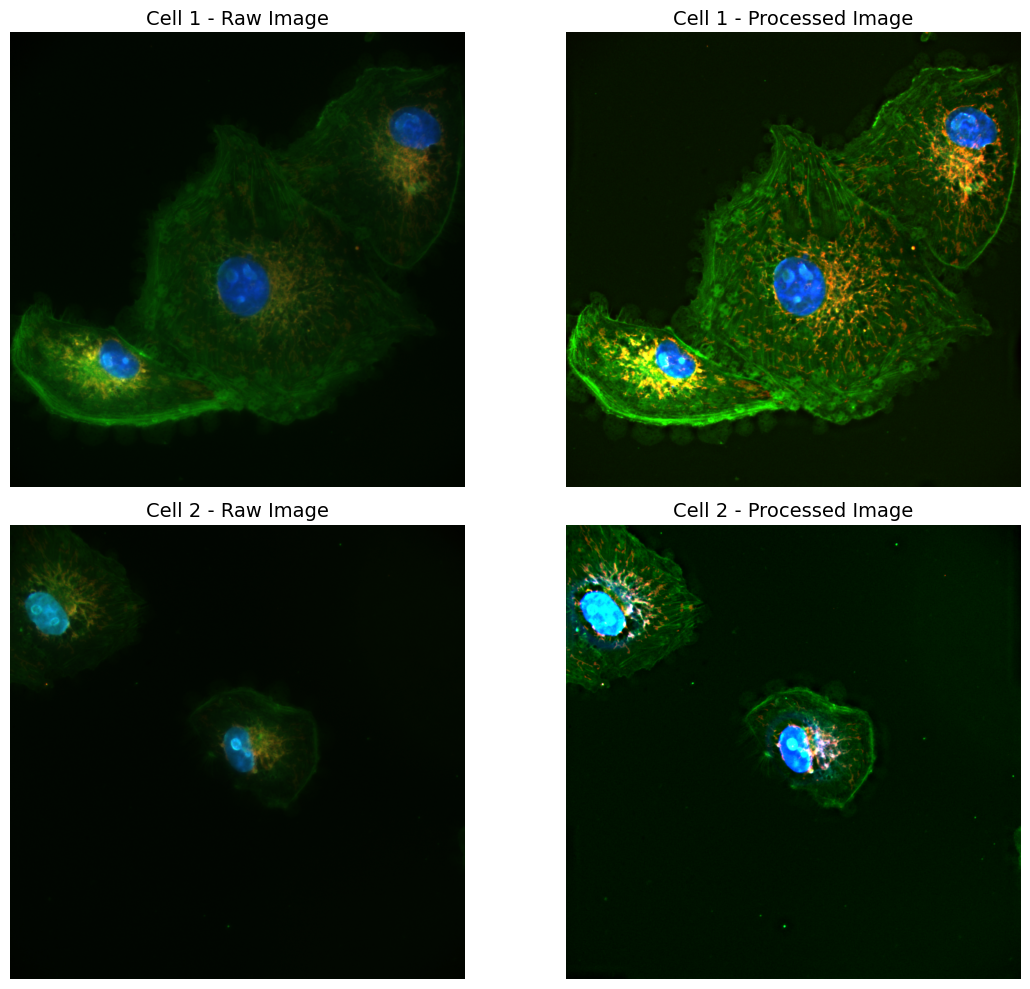

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np


cell1_raw_path = "output\cell_4_raw_rgb.tif"
cell1_enhanced_path = "output\cell_4_enhanced_rgb.tif"
cell2_raw_path = "output\cell_13_raw_rgb.tif"
cell2_enhanced_path = "output\cell_13_enhanced_rgb.tif"

# 读取图像后转为numpy数组（解决部分PIL图像imshow不兼容问题）
cell1_raw = np.array(Image.open(cell1_raw_path))
cell1_enhanced = np.array(Image.open(cell1_enhanced_path))
cell2_raw = np.array(Image.open(cell2_raw_path))
cell2_enhanced = np.array(Image.open(cell2_enhanced_path))

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].imshow(cell1_raw)
axes[0, 0].set_title("Cell 1 - Raw Image", fontsize=14)
axes[0, 0].axis('off') 

axes[0, 1].imshow(cell1_enhanced)
axes[0, 1].set_title("Cell 1 - Processed Image", fontsize=14)
axes[0, 1].axis('off')

axes[1, 0].imshow(cell2_raw)
axes[1, 0].set_title("Cell 2 - Raw Image", fontsize=14)
axes[1, 0].axis('off')

axes[1, 1].imshow(cell2_enhanced)
axes[1, 1].set_title("Cell 2 - Processed Image", fontsize=14)
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()